# Model Selection

The more I looked into the data the more I felt I needed to create two different types of models. One where we are dealing with a pre-approval loan data and the other where we have post-approval loan data. First, we explore the model selection process for pre-approval loans. 
My assumptions were: 
1. The features total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, last_pymnt_amnt and last_pymnt_d_mnth are information we would only know post-approval. 
2. The rest of the features we gathered pre-approval of the loan or features that we can figure out pre-approval of the loan. For example, term is probably determined before approving the loan. 
3. We want a model that predicts the likelihood that a person will fully pay their loan as well as classify it. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import accuracy_score, precision_recall_curve
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import BernoulliNB
sns.set(style='white')
sns.set(style='whitegrid',color_codes=True)
from imblearn.over_sampling import SMOTE
import pickle
from sklearn import metrics

C:\Users\ebish\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data=pd.read_csv("C:\\Users\\ebish\\Documents\\loan-status-prediction\\datasets\\zume_loans_train_dataset", sep=",",header=0,index_col=0)

In [3]:
def pre_or_post(data, pre=True):
    """Function takes preprocessed data and creates 
    either pre-approved dataset or post-approved dataset"""
    
    #decided to get rid of this feature since not all states are accounted for in training data
    data = data.drop(columns=['addr_state'])
    
    if pre == True:
        data = data.drop(columns=['total_pymnt','total_pymnt_inv','total_rec_prncp',
                                            'total_rec_int','total_rec_late_fee',
                                            'last_pymnt_amnt','last_pymnt_d_mnth'])
       
    return data
    


In [4]:
def dummy(data, pre=True):
    """
    Function takes preprocessed data 
    and one hot encodes all categoricial data
    """
    
    all_cat_vars = ['term','emp_length','home_ownership','purpose','pub_rec_bankruptcies_2cats','grade',
            'verification_status','issue_d_mnth',
            'earliest_cr_line_mnth','last_credit_pull_d_mnth',
            'delinq_2yrs_2cat','inq_last_6mths_2cats','pub_rec_2cats']
    
    if pre == True:
        
        #create dummy variables for categorical data
        for var in all_cat_vars:
            data = pd.concat([data,pd.get_dummies(data[var],prefix=var)],axis=1)
    
        data = data.drop(columns=all_cat_vars)
    
    else:
        all_cat_vars.append('last_pymnt_d_mnth')
        
        for var in all_cat_vars:
            data = pd.concat([data,pd.get_dummies(data[var],prefix=var)],axis=1)
    
        data = data.drop(columns=all_cat_vars)
    
    return data
    
    

In [5]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams.update({'font.size':22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.rcParams.update({'font.size':32})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
pre_train_data = pre_or_post(data)

In [7]:
# we are left with 25 features in the dataset after one hot encoding
pre_train_data.shape

(32830, 25)

In [8]:
pre_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32830 entries, 22066 to 37214
Data columns (total 25 columns):
loan_amnt                     32830 non-null float64
funded_amnt                   32830 non-null float64
funded_amnt_inv               32830 non-null float64
term                          32830 non-null object
int_rate                      32830 non-null float64
installment                   32830 non-null float64
grade                         32830 non-null object
emp_length                    32830 non-null object
home_ownership                32830 non-null object
annual_inc                    32830 non-null float64
verification_status           32830 non-null object
loan_status                   32830 non-null object
purpose                       32830 non-null object
dti                           32830 non-null float64
open_acc                      32830 non-null float64
revol_bal                     32830 non-null float64
revol_util                    32830 non-null f

In [9]:
dpre_train_data = dummy(pre_train_data)

In [10]:
X = dpre_train_data.drop(columns=['loan_status'])
y = dpre_train_data.loan_status

### Thinking ahead: Multicollinearity

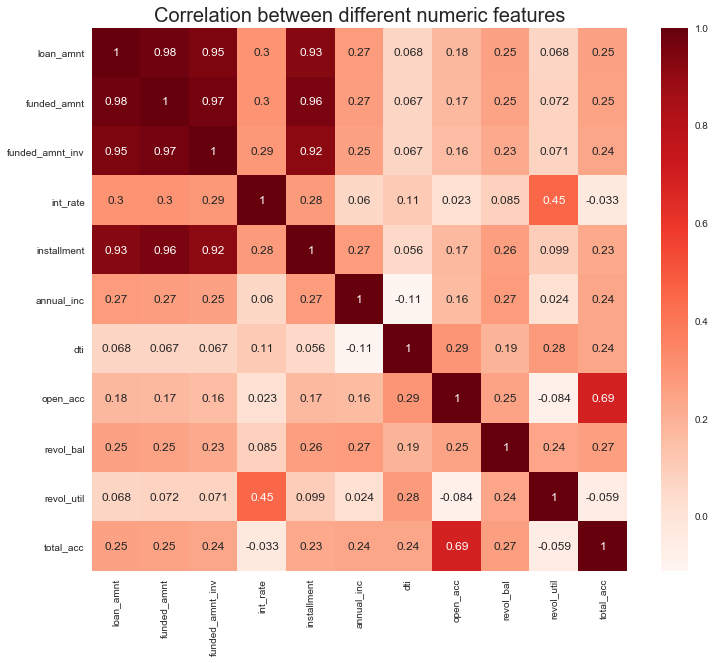

In [14]:
# using pearson correlation
plt.figure(figsize=(12,10))
cor = pre_train_data.corr()
ax = sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
ax.set_title("Correlation between different numeric features",size=20)
plt.show()


From this corrlelation matrix I decide to drop funded_amnt, funded_amnt_inv, and installments due to their high correlation and since we don't want multicollinearity. All other terms I decided were good enough.

In [11]:
#drop for multicollinearity purposes
multicollinearity = ['funded_amnt', 'funded_amnt_inv', 'installment']
X = X.drop(columns=multicollinearity)

In [12]:
scaler = MinMaxScaler()
X_n = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)


C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
x_train, x_val, y_train, y_val = train_test_split(X_n,y,test_size=.2,random_state=11)

## Baseline: Predict 

I'm using the most frequent group classification as our baseline. So if we just predicted everyone as Fully Paid we would get 85.87% accuracy in our validation dataset. We want to improve accuracy, but also will focus on the other measures to determine the best model.

In [14]:
y_pred_baseline = ['Fully Paid']*y_val.shape[0]
print(classification_report(y_val, y_pred_baseline, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.0000    0.0000    0.0000       928
  Fully Paid     0.8587    1.0000    0.9240      5638

   micro avg     0.8587    0.8587    0.8587      6566
   macro avg     0.4293    0.5000    0.4620      6566
weighted avg     0.7373    0.8587    0.7934      6566



C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Naive Bayes

Assumptions:
1. Independent predictors

In [15]:
nb = BernoulliNB()
nb.fit(x_train,y_train)
pred_nb = nb.predict(x_val)
print(classification_report(y_val, pred_nb, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.4982    0.4461    0.4707       928
  Fully Paid     0.9104    0.9260    0.9181      5638

   micro avg     0.8582    0.8582    0.8582      6566
   macro avg     0.7043    0.6861    0.6944      6566
weighted avg     0.8521    0.8582    0.8549      6566



## Logistic Regression 
Assumptions:
1. Independent variables should be independent of each other. Little or no multicollinearity.
2. Observations are independent of each other. 
3. Linearity of independent varaibles to log odds.
4. "Large" sample size.

### Model : Logistic Regressiong include all features

In [16]:
log_mod1 = LogisticRegressionCV(cv=5,penalty='l2', random_state=11,
                              max_iter=100, solver='liblinear').fit(x_train, y_train)

In [17]:
y_log_pred1 = log_mod1.predict(x_val)
print(classification_report(y_val, y_log_pred1, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.6510    0.3438    0.4499       928
  Fully Paid     0.8998    0.9697    0.9334      5638

   micro avg     0.8812    0.8812    0.8812      6566
   macro avg     0.7754    0.6567    0.6917      6566
weighted avg     0.8646    0.8812    0.8651      6566



Normalized confusion matrix
[[0.34375   0.65625  ]
 [0.0303299 0.9696701]]


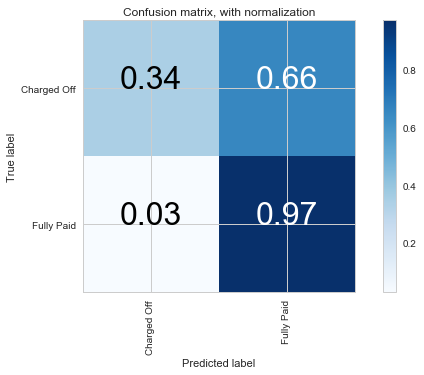

In [18]:
# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(confusion_matrix(y_val,y_log_pred1), classes=['Charged Off', 'Fully Paid'],
                      title='Confusion matrix, with normalization')
plt.show()

### Model: Logistic Regression including K Best Features

In [20]:
k = 94
k_acc = np.zeros(k)
k_co_f1_score = np.zeros(k)
k_fp_f1_score = np.zeros(k)
k_co_precision_score = np.zeros(k)
k_fp_precision_score = np.zeros(k)
k_co_recall_score = np.zeros(k)
k_fp_recall_score = np.zeros(k)

for i in range(k):
    fit = SelectKBest(chi2, k=i+1).fit(x_train, y_train)
    x_train_log2 = fit.transform(x_train)
    x_val_log2 = fit.transform(x_val)
    log_mod2 = LogisticRegressionCV(cv=5, penalty='l2', random_state=11, max_iter=100, class_weight={'Fully Paid':.5, 'Charged Off':.5})
    log_mod2.fit(x_train_log2, y_train)
    
    y_log_pred2 = log_mod2.predict(x_val_log2)
    k_acc[i] = log_mod2.score(x_val_log2, y_val)
    k_co_f1_score[i] = f1_score(y_val, y_log_pred2, pos_label='Charged Off')
    k_fp_f1_score[i] = f1_score(y_val, y_log_pred2, pos_label='Fully Paid')
    k_co_precision_score[i] = precision_score(y_val, y_log_pred2, pos_label='Charged Off')
    k_fp_precision_score[i] = precision_score(y_val, y_log_pred2, pos_label='Fully Paid')
    k_co_recall_score[i] = recall_score(y_val, y_log_pred2, pos_label='Charged Off')
    k_fp_recall_score[i] = recall_score(y_val, y_log_pred2, pos_label='Fully Paid')
    
    
    

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the 

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

Text(0,0.5,'Accuracy')

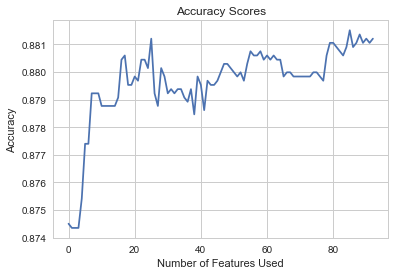

In [28]:
# Accuracy scores of different K Best Logistic Models
plt.plot(k_acc[1:])
plt.title('Accuracy Scores')
plt.xlabel('Number of Features Used')
plt.ylabel('Accuracy')
#plt.xticks(np.arange(0,k-2,step=5))

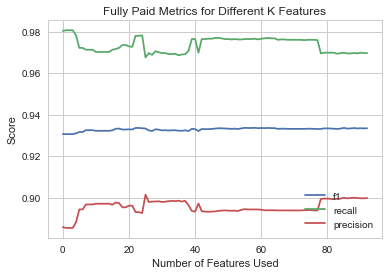

In [38]:
#plot of fully paid metrics
plt.plot(k_fp_f1_score[1:])
plt.plot(k_fp_recall_score[1:])
plt.plot(k_fp_precision_score[1:])
plt.title('Fully Paid Metrics for Different K Features')
plt.xlabel('Number of Features Used')
plt.ylabel('Score')
plt.legend(['f1', 'recall', 'precision'],loc='lower right')

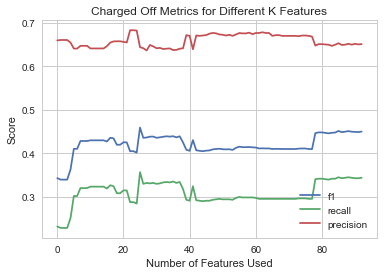

In [40]:
#plot of charged off metrics
plt.plot(k_co_f1_score[1:])
plt.plot(k_co_recall_score[1:])
plt.plot(k_co_precision_score[1:])
plt.title('Charged Off Metrics for Different K Features')
plt.xlabel('Number of Features Used')
plt.ylabel('Score')
plt.legend(['f1', 'recall', 'precision'],loc='lower right')

### From above analysis we pick the model below

In [14]:
#best based off analysis above
fit = SelectKBest(chi2, k=27).fit(x_train, y_train)
x_train_log2 = fit.transform(x_train)
x_val_log2 = fit.transform(x_val)

In [15]:
log_mod2 = LogisticRegressionCV(cv=5, penalty='l2',random_state=11, max_iter=100, class_weight={'Fully Paid':.5, 'Charged Off':.5})
log_mod2.fit(x_train_log2, y_train)

LogisticRegressionCV(Cs=10,
           class_weight={'Fully Paid': 0.5, 'Charged Off': 0.5}, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=11, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [16]:
y_log_pred2=log_mod2.predict(x_val_log2)
print(classification_report(y_val,y_log_pred2,digits=4))

              precision    recall  f1-score   support

 Charged Off     0.6440    0.3567    0.4591       928
  Fully Paid     0.9014    0.9675    0.9333      5638

   micro avg     0.8812    0.8812    0.8812      6566
   macro avg     0.7727    0.6621    0.6962      6566
weighted avg     0.8650    0.8812    0.8663      6566



### What are these top 27 features?

In [17]:
print("Features sorted by their rank:")
best_feat = sorted(zip(map(lambda x: round(x, 4), fit.scores_), x_train.columns), reverse=True)
print(best_feat)

Features sorted by their rank:
[(3684.6081, 'last_credit_pull_d_mnth_Oct'), (391.9983, 'term_ 60 months'), (360.0748, 'grade_A'), (215.0172, 'last_credit_pull_d_mnth_Mar'), (209.5094, 'last_credit_pull_d_mnth_Apr'), (198.6866, 'grade_E'), (163.3427, 'grade_D'), (162.6914, 'last_credit_pull_d_mnth_Jan'), (161.6706, 'purpose_small_business'), (147.7756, 'last_credit_pull_d_mnth_Sep'), (143.832, 'term_ 36 months'), (142.9806, 'grade_F'), (133.7368, 'last_credit_pull_d_mnth_Nov'), (124.9151, 'last_credit_pull_d_mnth_Jun'), (122.9646, 'last_credit_pull_d_mnth_Dec'), (113.9048, 'last_credit_pull_d_mnth_Jul'), (111.8051, 'int_rate'), (87.3843, 'inq_last_6mths_2cats_0'), (81.3538, 'last_credit_pull_d_mnth_May'), (78.6747, 'pub_rec_2cats_1+'), (76.7245, 'inq_last_6mths_2cats_1+'), (60.6763, 'grade_G'), (60.0236, 'pub_rec_bankruptcies_2cats_1+'), (54.4681, 'grade_B'), (51.891, 'last_credit_pull_d_mnth_Aug'), (47.787, 'last_credit_pull_d_mnth_Feb'), (42.4031, 'purpose_credit_card'), (40.6197, 're

### Model : What about the threshold value?

(0, 1)

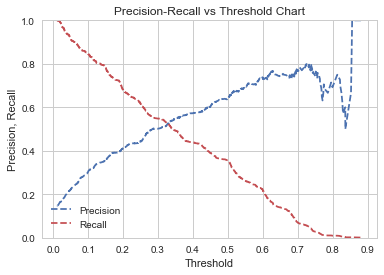

In [19]:
### Predict test_y values and probabilities based on fitted logistic regression model
pred_y_2 = log_mod2.predict(x_val_log2) 

probs_y = log_mod2.predict_proba(x_val_log2) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of 
#array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_val, probs_y[:,0], pos_label='Charged Off') 
   #retrieve probability of being 0(in first column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.xticks(np.arange(0, 1, step=.1))
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

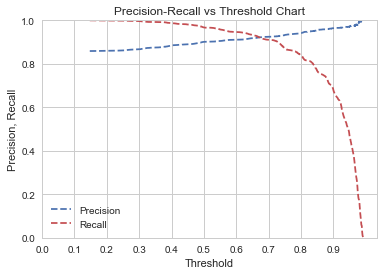

In [20]:
### Predict test_y values and probabilities based on fitted logistic regression model

pred_y_2 = log_mod2.predict(x_val_log2) 

probs_y = log_mod2.predict_proba(x_val_log2) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first column of 
#array) vs 1 (2nd column in array)

precision, recall, thresholds = precision_recall_curve(y_val, probs_y[:,1], pos_label='Fully Paid') 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.xticks(np.arange(0,1,step=.1))
plt.legend(loc="lower left")
plt.ylim([0,1])

In [21]:
## calculate new metric scores with new threshold value
yy = ['']*len(probs_y)
for i in range(len(probs_y[:,0])):
    if probs_y[i,1] > .67:
        yy[i] = 'Fully Paid'
    else:
        yy[i] = 'Charged Off'


In [22]:
print(classification_report(y_val, yy,digits=4))

              precision    recall  f1-score   support

 Charged Off     0.5255    0.5216    0.5235       928
  Fully Paid     0.9213    0.9225    0.9219      5638

   micro avg     0.8658    0.8658    0.8658      6566
   macro avg     0.7234    0.7220    0.7227      6566
weighted avg     0.8654    0.8658    0.8656      6566



0.8658239415169052
Normalized confusion matrix
[[0.52155172 0.47844828]
 [0.07750976 0.92249024]]


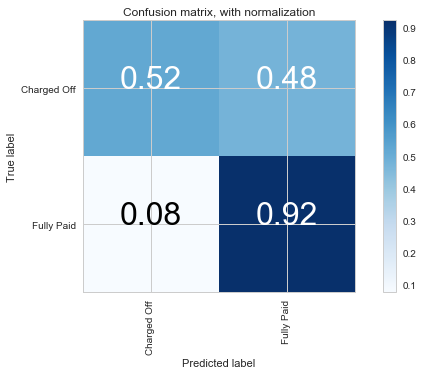

In [23]:
print(accuracy_score(yy,y_val))
confusion_matrix(y_val,yy)
# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(confusion_matrix(y_val,yy), classes=['Charged Off', 'Fully Paid'],
                      title='Confusion matrix, with normalization')
plt.show()
#plot_confusion_matrix(y_val,y_log_pred1)

### Model: Feature Selection via RFE

In [51]:
log_mod3 = LogisticRegressionCV(cv=5, penalty='l2', random_state=11, max_iter=100)

In [52]:
rfe = RFE(log_mod3,27)
rfe = rfe.fit(x_train,y_train)

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

In [53]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_train.columns)))

Features sorted by their rank:
[(1, 'annual_inc'), (1, 'dti'), (1, 'emp_length_Unknown'), (1, 'home_ownership_OTHER'), (1, 'inq_last_6mths_2cats_1+'), (1, 'int_rate'), (1, 'last_credit_pull_d_mnth_Apr'), (1, 'last_credit_pull_d_mnth_Aug'), (1, 'last_credit_pull_d_mnth_Feb'), (1, 'last_credit_pull_d_mnth_Jan'), (1, 'last_credit_pull_d_mnth_Jun'), (1, 'last_credit_pull_d_mnth_Mar'), (1, 'last_credit_pull_d_mnth_May'), (1, 'last_credit_pull_d_mnth_Oct'), (1, 'last_credit_pull_d_mnth_Sep'), (1, 'pub_rec_2cats_1+'), (1, 'purpose_car'), (1, 'purpose_credit_card'), (1, 'purpose_debt_consolidation'), (1, 'purpose_educational'), (1, 'purpose_home_improvement'), (1, 'purpose_major_purchase'), (1, 'purpose_small_business'), (1, 'purpose_wedding'), (1, 'revol_bal'), (1, 'revol_util'), (1, 'term_ 60 months'), (2, 'last_credit_pull_d_mnth_Nov'), (3, 'last_credit_pull_d_mnth_Dec'), (4, 'last_credit_pull_d_mnth_Jul'), (5, 'earliest_cr_line_mnth_Nov'), (6, 'purpose_renewable_energy'), (7, 'issue_d_mnth

In [54]:
#build features so we can transform data with top 27 features from RFE
col = np.empty(27, dtype=object)
j = 0
for i in range(len(x_train.columns)):
    if rfe.ranking_[i] == 1:
        col[j] = x_train.columns[i]
        j = j+1

In [55]:
#these are the top 27 features from RFE
col

array(['int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util',
       'term_ 60 months', 'emp_length_Unknown', 'home_ownership_OTHER',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement',
       'purpose_major_purchase', 'purpose_small_business',
       'purpose_wedding', 'last_credit_pull_d_mnth_Apr',
       'last_credit_pull_d_mnth_Aug', 'last_credit_pull_d_mnth_Feb',
       'last_credit_pull_d_mnth_Jan', 'last_credit_pull_d_mnth_Jun',
       'last_credit_pull_d_mnth_Mar', 'last_credit_pull_d_mnth_May',
       'last_credit_pull_d_mnth_Oct', 'last_credit_pull_d_mnth_Sep',
       'inq_last_6mths_2cats_1+', 'pub_rec_2cats_1+'], dtype=object)

In [56]:
x_train_log3 = x_train[col]
x_val_log3 = x_val[col]

In [57]:
#log_mod3=LogisticRegressionCV(cv=5,penalty='l2',random_state=11,max_iter=100,class_weight={'Fully Paid':.5, 'Charged Off':.5})
log_mod3.fit(x_train_log3, y_train)

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=11,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [58]:
y_log_pred3 = log_mod3.predict(x_val_log3)
print(classification_report(y_val, y_log_pred3, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.6531    0.3448    0.4513       928
  Fully Paid     0.8999    0.9698    0.9336      5638

   micro avg     0.8815    0.8815    0.8815      6566
   macro avg     0.7765    0.6573    0.6925      6566
weighted avg     0.8650    0.8815    0.8654      6566



### What if I used Smote?

In [59]:
smt = SMOTE()
x_smote,y_smote = smt.fit_sample(x_train_log3, y_train)
x_smote_df = pd.DataFrame(data=x_smote, columns=x_train_log3.columns)
y_smote_df = pd.DataFrame(data=y_smote, columns=['loan_status'])

In [60]:
log_mod3.fit(x_smote_df,y_smote_df)
y_logsmote_pred3 = log_mod3.predict(x_val_log3)
print(classification_report(y_val, y_logsmote_pred3, digits=4))

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

 Charged Off     0.3662    0.7802    0.4985       928
  Fully Paid     0.9555    0.7778    0.8575      5638

   micro avg     0.7781    0.7781    0.7781      6566
   macro avg     0.6609    0.7790    0.6780      6566
weighted avg     0.8723    0.7781    0.8068      6566



# Post Loan Models

In [24]:
post_train_data = pre_or_post(data, pre=False)
post_train_data = dummy(post_train_data, pre=False)

X_p = post_train_data.drop(columns=['loan_status'])
y_p = post_train_data.loan_status

X_p = X_p.drop(columns=['funded_amnt', 'funded_amnt_inv', 'installment'])

scaler_p = MinMaxScaler()
X_n_p = pd.DataFrame(scaler_p.fit_transform(X_p), columns=X_p.columns)

x_train_p, x_val_p, y_train_p, y_val_p =train_test_split(X_n_p, y, test_size=.2, random_state=11)

C:\Users\ebish\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


## Naive Bayes

### Post Approval Model: Naive Bayes

In [29]:
nb_p = BernoulliNB()
nb_p.fit(x_train_p, y_train_p)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [30]:
pred_nb_p = nb_p.predict(x_val_p)
print(classification_report(y_val_p, pred_nb_p, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.5222    0.4698    0.4946       928
  Fully Paid     0.9142    0.9292    0.9216      5638

   micro avg     0.8643    0.8643    0.8643      6566
   macro avg     0.7182    0.6995    0.7081      6566
weighted avg     0.8587    0.8643    0.8613      6566



## Logistic Regression

### Post Approval Model: Logistic Regression with all the features

In [25]:
log_mod1_p = LogisticRegressionCV(cv=5, penalty='l2', random_state=11, max_iter=100, solver='liblinear').fit(x_train_p, y_train_p)
y_log_pred1_p = log_mod1_p.predict(x_val_p)
print(classification_report(y_val_p, y_log_pred1_p, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.9804    0.9159    0.9471       928
  Fully Paid     0.9863    0.9970    0.9916      5638

   micro avg     0.9855    0.9855    0.9855      6566
   macro avg     0.9834    0.9565    0.9693      6566
weighted avg     0.9855    0.9855    0.9853      6566



[[ 850   78]
 [  17 5621]]
Normalized confusion matrix
[[0.91594828 0.08405172]
 [0.00301525 0.99698475]]


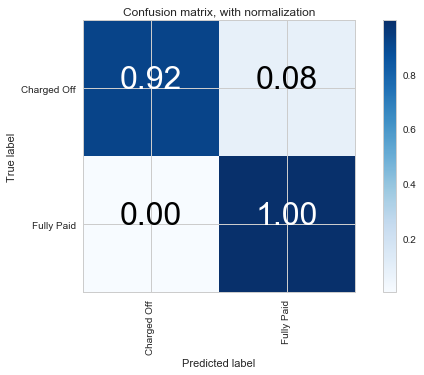

In [26]:
print(confusion_matrix(y_val_p, y_log_pred1_p))
# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(confusion_matrix(y_val_p, y_log_pred1_p), classes=['Charged Off', 'Fully Paid'],
                      title='Confusion matrix, with normalization')
plt.show()

### Post Approval Model: Logistic Regression including K Best Features

In [27]:
fit_p = SelectKBest(chi2, k=30).fit(x_train_p, y_train_p)
x_train_p_log2 = fit_p.transform(x_train_p)
x_val_p_log2 = fit_p.transform(x_val_p)

In [28]:
log_mod2_p = LogisticRegressionCV(cv=5, penalty='l2', random_state=11, max_iter=300, class_weight={'Fully Paid':.5, 'Charged Off':.5})
log_mod2_p.fit(x_train_p_log2, y_train_p)

LogisticRegressionCV(Cs=10,
           class_weight={'Fully Paid': 0.5, 'Charged Off': 0.5}, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=300, multi_class='warn', n_jobs=None, penalty='l2',
           random_state=11, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [29]:
y_log_pred2 = log_mod2_p.predict(x_val_p_log2)
print(classification_report(y_val_p, y_log_pred2, digits=4))

              precision    recall  f1-score   support

 Charged Off     0.8919    0.7823    0.8335       928
  Fully Paid     0.9649    0.9844    0.9745      5638

   micro avg     0.9558    0.9558    0.9558      6566
   macro avg     0.9284    0.8834    0.9040      6566
weighted avg     0.9546    0.9558    0.9546      6566



### What are these top features?

In [30]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), fit.scores_), x_train_p.columns),reverse=True))

Features sorted by their rank:
[(3684.6081, 'last_credit_pull_d_mnth_Jan'), (391.9983, 'total_pymnt_inv'), (360.0748, 'purpose_renewable_energy'), (215.0172, 'last_credit_pull_d_mnth_Aug'), (209.5094, 'earliest_cr_line_mnth_Jun'), (198.6866, 'pub_rec_bankruptcies_2cats_0'), (163.3427, 'purpose_wedding'), (162.6914, 'earliest_cr_line_mnth_Oct'), (161.6706, 'purpose_house'), (147.7756, 'last_credit_pull_d_mnth_Jul'), (143.832, 'total_pymnt'), (142.9806, 'pub_rec_bankruptcies_2cats_1+'), (133.7368, 'last_credit_pull_d_mnth_Feb'), (124.9151, 'last_credit_pull_d_mnth_Apr'), (122.9646, 'earliest_cr_line_mnth_May'), (113.9048, 'earliest_cr_line_mnth_Sep'), (111.8051, 'int_rate'), (87.3843, 'last_credit_pull_d_mnth_May'), (81.3538, 'last_credit_pull_d_mnth_Dec'), (78.6747, 'last_credit_pull_d_mnth_Sep'), (76.7245, 'last_credit_pull_d_mnth_Nov'), (60.6763, 'grade_A'), (60.0236, 'purpose_other'), (54.4681, 'purpose_small_business'), (51.891, 'earliest_cr_line_mnth_Mar'), (47.787, 'earliest_cr_li

# Final Model Selection

In [31]:
model_scores = pd.read_csv("C:\\Users\\ebish\\Documents\\loan-status-prediction\\metadata\\model_scores.csv",sep=',',header=0)

In [32]:
model_scores

,model_name,normalized,feature_shape,accuracy,precision_co,precision_fp,recall_co,recall_fp,f1_co,f1_fp
0,baseline,N,0,0.8587,0.0000,0.8587,0.0000,1.0000,0.0000,0.9240
1,log_mod1,Y,98,0.8812,0.6510,0.8998,0.3438,0.9697,0.4499,0.9334
2,log_mod2,Y,27,0.8812,0.6440,0.9014,0.3567,0.9675,0.4592,0.9333
3,log_mod_2_threshold,Y,27,0.8658,0.5255,0.9225,0.5216,0.9225,0.5235,0.9219
4,log_mod3,Y,27,0.8815,0.6531,0.8999,0.3448,0.9698,0.4513,0.9336
5,log_mod3_smote,Y,27,0.7799,0.3683,0.9555,0.7791,0.7801,0.5002,0.8589
6,nb,Y,94,0.8582,0.4982,0.9104,0.4461,0.9260,0.4707,0.9181
7,nb_p,Y,116,0.8981,0.7403,0.9122,0.4300,0.9752,0.5440,0.9426
8,log_mod1_p,Y,116,0.9855,0.9804,0.9863,0.9159,0.9970,0.9471,0.9916
9,log_mod2_p,Y,30,0.9558,0.8919,0.9649,0.7823,0.9844,0.8335,0.9745


# Conclusion
Choosing the best model really depends on what kind of information wants to be gained. If we only care about accuracy and no post-approval data then we would pick Model log_mod1, log_mod2, or log_mod3. If we add another condition that we want model training to be quick then log_mod2 would probably be the best out of those three. There are so many other questions that could be asked.

Personally, I would assume that we would want a model that minimizes our false negatives in this case meaning I would want to minimize the case where we predict Fully Paid when it is in fact Charged Off. This feature would be to maximize recall. In this case we would choose log_mod_2_threshold. Overall, it depends on the clients ultimate needs. 

Also, we see that the post-approval models did quite well in all metrics. This makes sense since the features included contained more evidence of when a borrower was paying or not. 

Ultimately, I chose log_mod2 for the application. It is easy to change to different needs.

# Predict Test Dataset Values

In [33]:
test = pd.read_csv("C:\\Users\\ebish\\Documents\\loan-status-prediction\\datasets\\zume_loans_test_dataset", sep=",", header=0, index_col=0)

In [34]:
# pre-approval
test_pre = pre_or_post(test, pre=True)
test_pre = dummy(test_pre, pre=True)
test_pre.drop(columns=multicollinearity, inplace=True)

index_values = test_pre.index.tolist()

test_pre = pd.DataFrame(scaler.transform(test_pre), columns=X_n.columns)
test_pre = fit.transform(test_pre)
test_pre_predict_label = log_mod2.predict(test_pre)
test_pre_predict_prob = log_mod2.predict_proba(test_pre)[:,1]

In [35]:
test_pre_predict_label = pd.DataFrame(list(zip( index_values, test_pre_predict_label)), index=index_values, columns=['index', 'predicted_loan_status'])
test_pre_predict_prob = pd.DataFrame(list(zip( index_values, test_pre_predict_prob)), index=index_values, columns=['index','loan_status_prob_fp'])

In [36]:
print(test_pre_predict_label.head())
print(test_pre_predict_prob.head())

       index predicted_loan_status
14944  14944            Fully Paid
9718    9718            Fully Paid
11006  11006            Fully Paid
6094    6094            Fully Paid
22390  22390            Fully Paid
       index  loan_status_prob_fp
14944  14944             0.909779
9718    9718             0.897646
11006  11006             0.976467
6094    6094             0.828797
22390  22390             0.983511


In [37]:
# with threshold value
y_test_pre = ['']*len(test_pre_predict_label)
for i in range(len(test_pre_predict_label)):
    if test_pre_predict_prob.values[i,1]> .67:
        y_test_pre[i] = 'Fully Paid'
    else:
        y_test_pre[i] = 'Charged Off'

In [38]:
test_threspre_predict_label = pd.DataFrame(list(zip(index_values, y_test_pre)), index=index_values, columns=['index', 'predicted_loan_status'])
test_threspre_predict_prob = test_pre_predict_prob

In [39]:
# post-approval and if I am just going for overall accuracy
test_post = pre_or_post(test, pre=False)
test_post = dummy(test_post, pre=False)
test_post.drop(columns=multicollinearity, inplace=True)

index_values_post=test_post.index.tolist()

test_post = pd.DataFrame(scaler_p.transform(test_post), columns=X_n_p.columns)
#test_post = fit_p.transform(test_post) 
test_post_predict_label = log_mod1_p.predict(test_post)
test_post_predict_prob = log_mod1_p.predict_proba(test_post)[:,1]

In [40]:
test_post_predict_label = pd.DataFrame(list(zip( index_values, test_post_predict_label)), index=index_values_post, columns=['index', 'predicted_loan_status'])
test_post_predict_prob = pd.DataFrame(list(zip( index_values, test_post_predict_prob)), index=index_values_post, columns=['index', 'loan_status_prob_fp'])

In [41]:
print(test_post_predict_label.head())
print(test_post_predict_prob.head())

       index predicted_loan_status
14944  14944            Fully Paid
9718    9718            Fully Paid
11006  11006            Fully Paid
6094    6094            Fully Paid
22390  22390            Fully Paid
       index  loan_status_prob_fp
14944  14944             0.999783
9718    9718             0.965568
11006  11006             0.999042
6094    6094             0.997478
22390  22390             0.999646


## Save files as pickle files

In [52]:
filename = 'pickle_files/model.pkl'
with open(filename,'wb') as f:
    pickle.dump(log_mod2, f)

In [53]:
filename = 'pickle_files/fit.pkl'
with open(filename,'wb') as f:
    pickle.dump(fit, f)

In [54]:
filename = 'pickle_files/scaler.pkl'
with open(filename,'wb') as f:
    pickle.dump(scaler, f)

In [55]:
filename = 'pickle_files/cols.pkl'
with open(filename,'wb') as f:
    pickle.dump(x_train.columns, f)

In [99]:
filename = 'predictions/test_pre_predict_label.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_pre_predict_label, f)
    
filename = 'predictions/test_pre_predict_prob.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_pre_predict_prob, f)

In [100]:
filename = 'predictions/test_threspre_predict_label.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_threspre_predict_label, f)
    
filename = 'predictions/test_threspre_predict_prob.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_threspre_predict_prob, f)

In [101]:
filename = 'predictions/test_post_predict_label.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_post_predict_label, f)
    
filename = 'predictions/test_post_predict_prob.pkl'
with open(filename, 'wb') as f:
    pickle.dump(test_post_predict_prob, f)